In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-classification/twitter_test.csv
/kaggle/input/twitter-sentiment-classification/twitter_training.csv


In [2]:
!pip install -U scikit-learn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 64.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, GRU, Embedding, Dropout, 
                                     Bidirectional, Input, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Imbalance handling
from imblearn.over_sampling import SMOTE

print(" All libraries imported successfully!")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
2025-11-06 01:43:42.022377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762393422.282473      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762393422.354057      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 All libraries imported successfully!


In [4]:
train_df = pd.read_csv('/kaggle/input/twitter-sentiment-classification/twitter_training.csv')
test_df = pd.read_csv('/kaggle/input/twitter-sentiment-classification/twitter_test.csv')

print(f"Train shape: {train_df.shape}")
print(f" Test shape: {test_df.shape}")
print("\n" + "="*50)
print("First 5 rows of training data:")
print(train_df.head())


Train shape: (74681, 4)
 Test shape: (999, 4)

First 5 rows of training data:
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     


In [5]:
train_df = train_df.copy()
train_df.columns = ['id', 'topic', 'sentiment', 'text']  
train_df.head()

,id,topic,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
print("\n" + "="*50)
print(" EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic Info
print("\n1️ Dataset Info:")
print(train_df.info())
print("\n2️ Missing Values:")
print(train_df.isnull().sum())
print("\n3️ Basic Statistics:")
print(train_df.describe())



 EXPLORATORY DATA ANALYSIS

1️ Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   topic      74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None

2️ Missing Values:
id             0
topic          0
sentiment      0
text         686
dtype: int64

3️ Basic Statistics:
                 id
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


In [7]:
print("\n Class Distribution:")
class_counts = train_df['sentiment'].value_counts()
print(class_counts)
print(f"\nClass Percentages:")
print(train_df['sentiment'].value_counts(normalize=True) * 100)



 Class Distribution:
sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Class Percentages:
sentiment
Negative      30.184384
Positive      27.893306
Neutral       24.528327
Irrelevant    17.393982
Name: proportion, dtype: float64


In [8]:
test_df = pd.read_csv("/kaggle/input/twitter-sentiment-classification/twitter_test.csv", header=None)


In [9]:
test_df.columns = ['id', 'topic', 'sentiment', 'text']


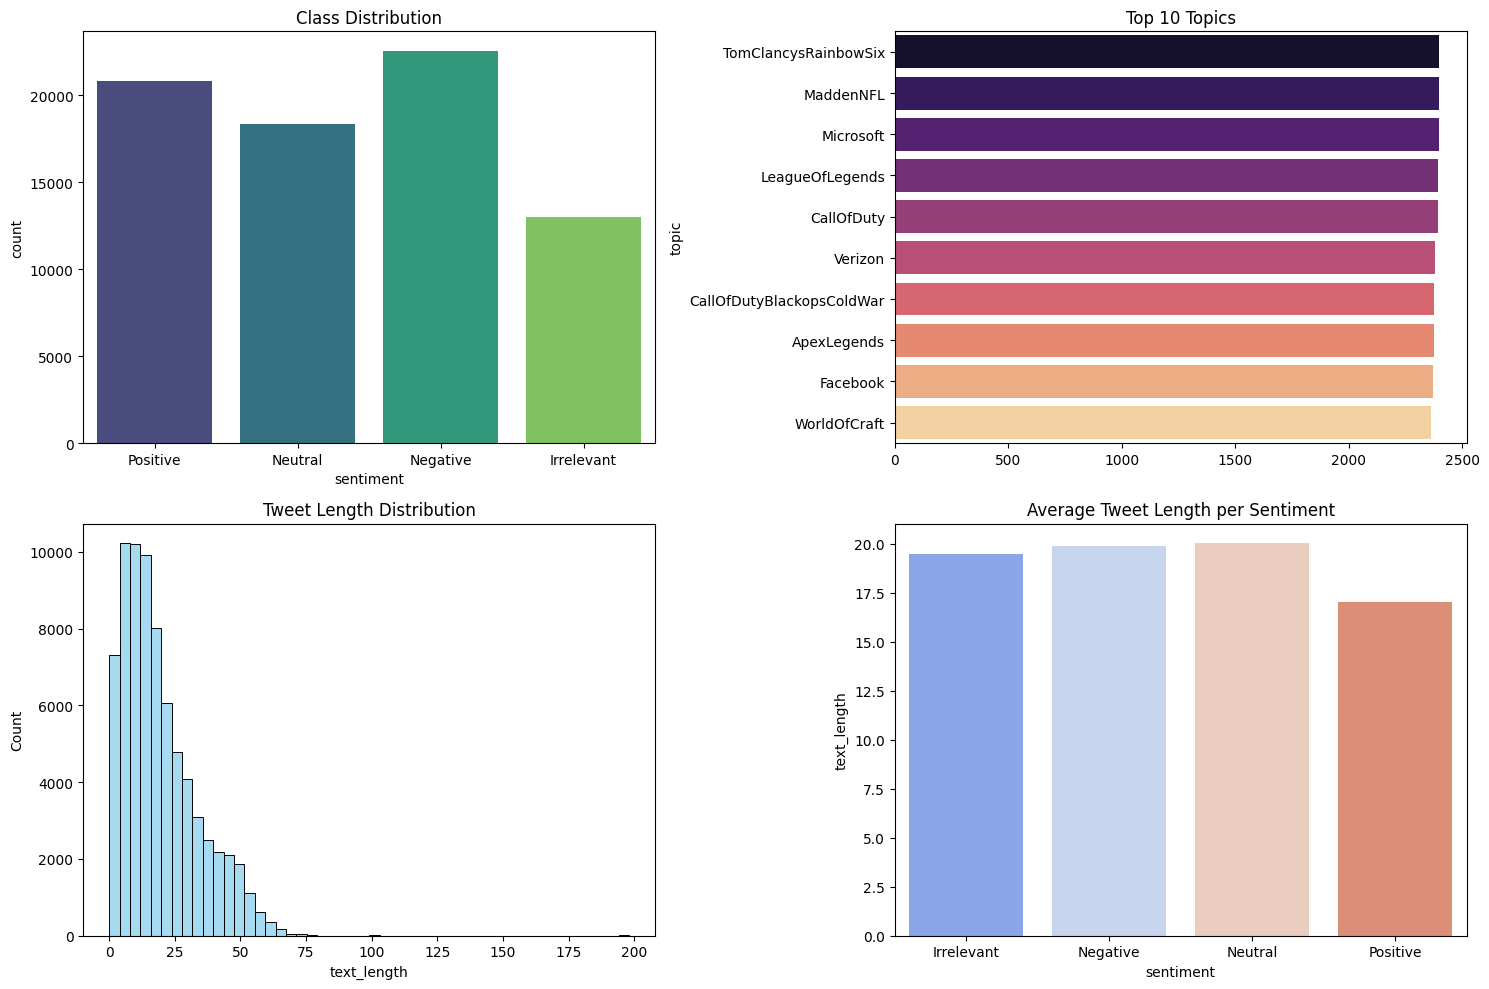

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(data=train_df, x='sentiment', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Class Distribution')

top_topics = train_df['topic'].value_counts().head(10)
sns.barplot(x=top_topics.values, y=top_topics.index, palette='magma', ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Topics')

train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(train_df['text_length'], bins=50, color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('Tweet Length Distribution')

avg_len = train_df.groupby('sentiment')['text_length'].mean().reset_index()
sns.barplot(x='sentiment', y='text_length', data=avg_len, palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Average Tweet Length per Sentiment')

plt.tight_layout()
plt.show()


In [15]:
# More Statistics
print("\n Text Length Statistics:")
print(train_df.groupby('sentiment')['text_length'].describe())



 Text Length Statistics:
              count       mean        std  min   25%   50%   75%    max
sentiment                                                              
Irrelevant  12990.0  19.466205  14.285915  0.0   8.0  16.0  28.0  163.0
Negative    22542.0  19.891669  14.969074  0.0   8.0  16.0  29.0  198.0
Neutral     18318.0  20.027787  14.241421  0.0  10.0  17.0  28.0  198.0
Positive    20831.0  17.053190  14.071802  0.0   6.0  13.0  24.0  198.0


In [14]:
print(train_df.columns)

Index(['id', 'topic', 'sentiment', 'text', 'text_length', 'cleaned_text'], dtype='object')


In [12]:
print(" TEXT PREPROCESSING")
def clean_text(text):
    """Clean and preprocess text"""
    # Convert to string
    text = str(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text):
    """Full preprocessing pipeline"""
    # Clean
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join back
    return ' '.join(tokens)
print("Processing training data...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
print("Processing test data...")
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

print(" Preprocessing completed!")
print("\nExample of preprocessing:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Cleaned: {train_df['cleaned_text'].iloc[0]}")

 TEXT PREPROCESSING
Processing training data...
Processing test data...
 Preprocessing completed!

Example of preprocessing:
Original: I am coming to the borders and I will kill you all,
Cleaned: coming border kill


In [19]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s!?]', '', text)  # حافظي على ! و ? 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    stop_words.discard('no')
    stop_words.discard('not')

    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)
print("Processing training data...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
print("Processing test data...")
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

print(" Preprocessing completed!")
print("\nExample of preprocessing:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Cleaned: {train_df['cleaned_text'].iloc[0]}")

Processing training data...
Processing test data...
 Preprocessing completed!

Example of preprocessing:
Original: I am coming to the borders and I will kill you all,
Cleaned: coming border kill


In [16]:

label_map = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Irrelevant': 3
}

train_df['label'] = train_df['sentiment'].map(label_map)
test_df['label'] = test_df['sentiment'].map(label_map)

print("Missing labels in train:", train_df['label'].isna().sum())
print("Missing labels in test:", test_df['label'].isna().sum())

X_train = train_df['cleaned_text'].values
y_train = train_df['label'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['label'].values

# ===============================
# 🔤 Tokenization
# ===============================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

MAX_WORDS = 10000 
MAX_LEN = 100       

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print("Data preprocessing completed successfully!")
print(f"X_train shape: {X_train_pad.shape}")
print(f"y_train shape: {y_train_cat.shape}")


Missing labels in train: 0
Missing labels in test: 0
Data preprocessing completed successfully!
X_train shape: (74681, 100)
y_train shape: (74681, 4)


In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, weight in class_weight_dict.items():
    class_name = [k for k, v in label_map.items() if v == i][0]
    print(f"{class_name}: {weight:.2f}")

Class weights:
Negative: 0.83
Neutral: 1.02
Positive: 0.90
Irrelevant: 1.44


In [21]:


EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.5
NUM_CLASSES = 4  

# Model 1: Simple LSTM
def build_lstm_model():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dropout(DROPOUT_RATE),
        Dense(32, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Model 2: Simple GRU
def build_gru_model():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        GRU(LSTM_UNITS, return_sequences=False),
        Dropout(DROPOUT_RATE),
        Dense(32, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Model 3: Bidirectional LSTM
def build_bilstm_model():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
        Dropout(DROPOUT_RATE),
        Dense(32, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Model 4: Bidirectional GRU
def build_bigru_model():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(GRU(LSTM_UNITS, return_sequences=False)),
        Dropout(DROPOUT_RATE),
        Dense(32, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model




In [23]:

print("\n" + "="*50)
print(" TRAINING ALL MODELS")
print("="*50)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

results = {}
models_dict = {
   
    'BiLSTM': build_bilstm_model,
    'BiGRU': build_bigru_model
}

for model_name, model_builder in models_dict.items():
    print(f"\n{'='*50}")
    print(f" Training {model_name} Model")
    print(f"{'='*50}")
    
    # Build and compile model
    model = model_builder()
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train_pad, y_train_cat,
        validation_data=(X_test_pad, y_test_cat),
        epochs=30,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
    print(f" {model_name} - Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")

    # Predictions
    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Save model results
    results[model_name] = {
        'model': model,
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'y_pred': y_pred_classes
    }
    
    # Clear session before next model (لتجنب تداخل الموديلات)
    import tensorflow as tf
    tf.keras.backend.clear_session()




 TRAINING ALL MODELS

 Training BiLSTM Model
Epoch 1/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 164s 67ms/step - accuracy: 0.4862 - loss: 1.1509 - val_accuracy: 0.8430 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 2/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 164s 70ms/step - accuracy: 0.7781 - loss: 0.6225 - val_accuracy: 0.8990 - val_loss: 0.3214 - learning_rate: 0.0010
Epoch 3/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 160s 69ms/step - accuracy: 0.8340 - loss: 0.4670 - val_accuracy: 0.9130 - val_loss: 0.2725 - learning_rate: 0.0010
Epoch 4/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 160s 68ms/step - accuracy: 0.8576 - loss: 0.3891 - val_accuracy: 0.9340 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 5/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 158s 68ms/step - accuracy: 0.8802 - loss: 0.3291 - val_accuracy: 0.9420 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 6/30
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 160s 69ms/step - accuracy: 0.8920 - loss: 0.2913 - val_accuracy: 0.9320 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 7/30
2

In [24]:

# ============================================
# 9. COMPARE MODELS
# ============================================

print(" MODEL COMPARISON")


comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['test_accuracy']*100 for m in results.keys()],
    'Test Loss': [results[m]['test_loss'] for m in results.keys()]
}).sort_values('Test Accuracy', ascending=False)

print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_acc = comparison_df.iloc[0]['Test Accuracy']

print(f"\n Best Model: {best_model_name}")
print(f"Best Accuracy: {best_acc:.2f}%")

best_model.save(f'best_sentiment_model_{best_model_name}.h5')
print(f"\n Saved best model as 'best_sentiment_model_{best_model_name}.h5'")


 MODEL COMPARISON
 Model  Test Accuracy  Test Loss
BiLSTM      94.800001   0.187271
 BiGRU      94.400001   0.191962

 Best Model: BiLSTM
Best Accuracy: 94.80%

 Saved best model as 'best_sentiment_model_BiLSTM.h5'


In [25]:

y_pred_best = results[best_model_name]['y_pred']


print("\n📋 Classification Report:")
target_names = ['Negative', 'Neutral', 'Positive','Irrelevant']
print(classification_report(y_test, y_pred_best, target_names=target_names))



📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96       266
     Neutral       0.99      0.93      0.96       285
    Positive       0.93      0.96      0.95       277
  Irrelevant       0.89      0.96      0.92       172

    accuracy                           0.95      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



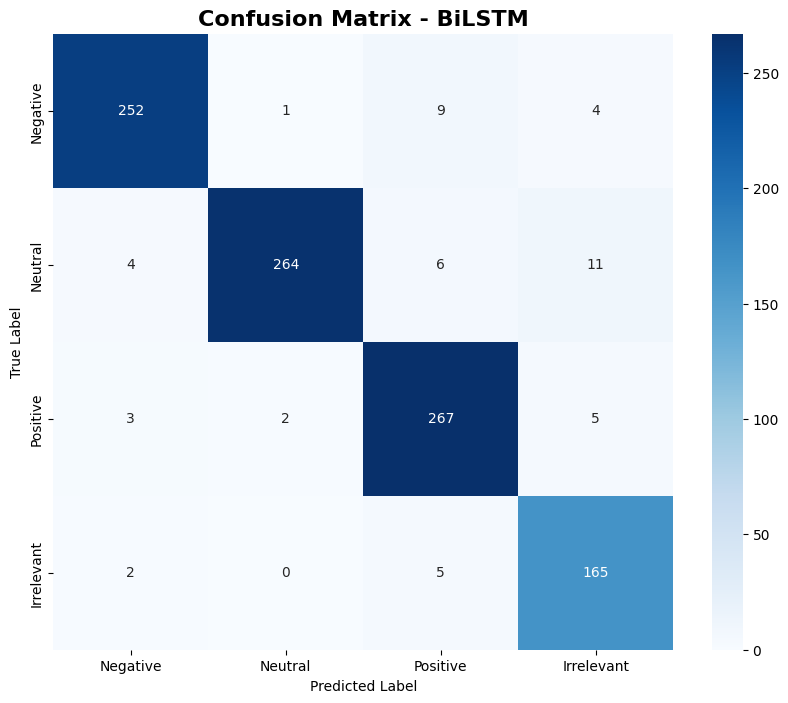

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


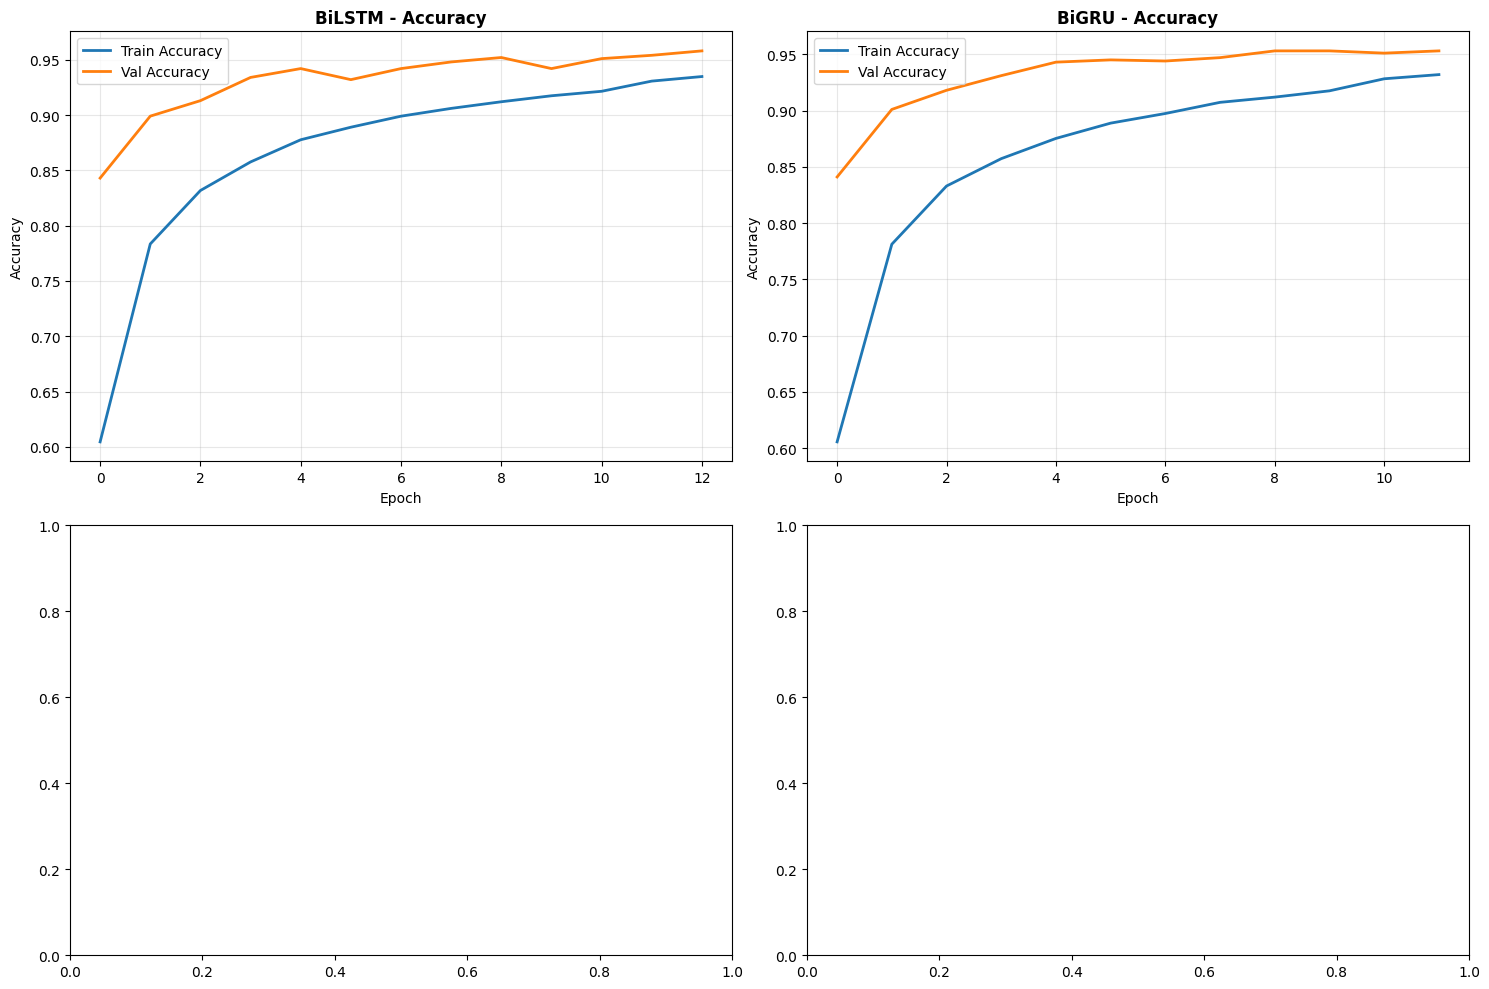

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (model_name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
        
    history = result['history']
    
    axes[row, col].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[row, col].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[row, col].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 12. SAVE TOKENIZER FOR DEPLOYMENT

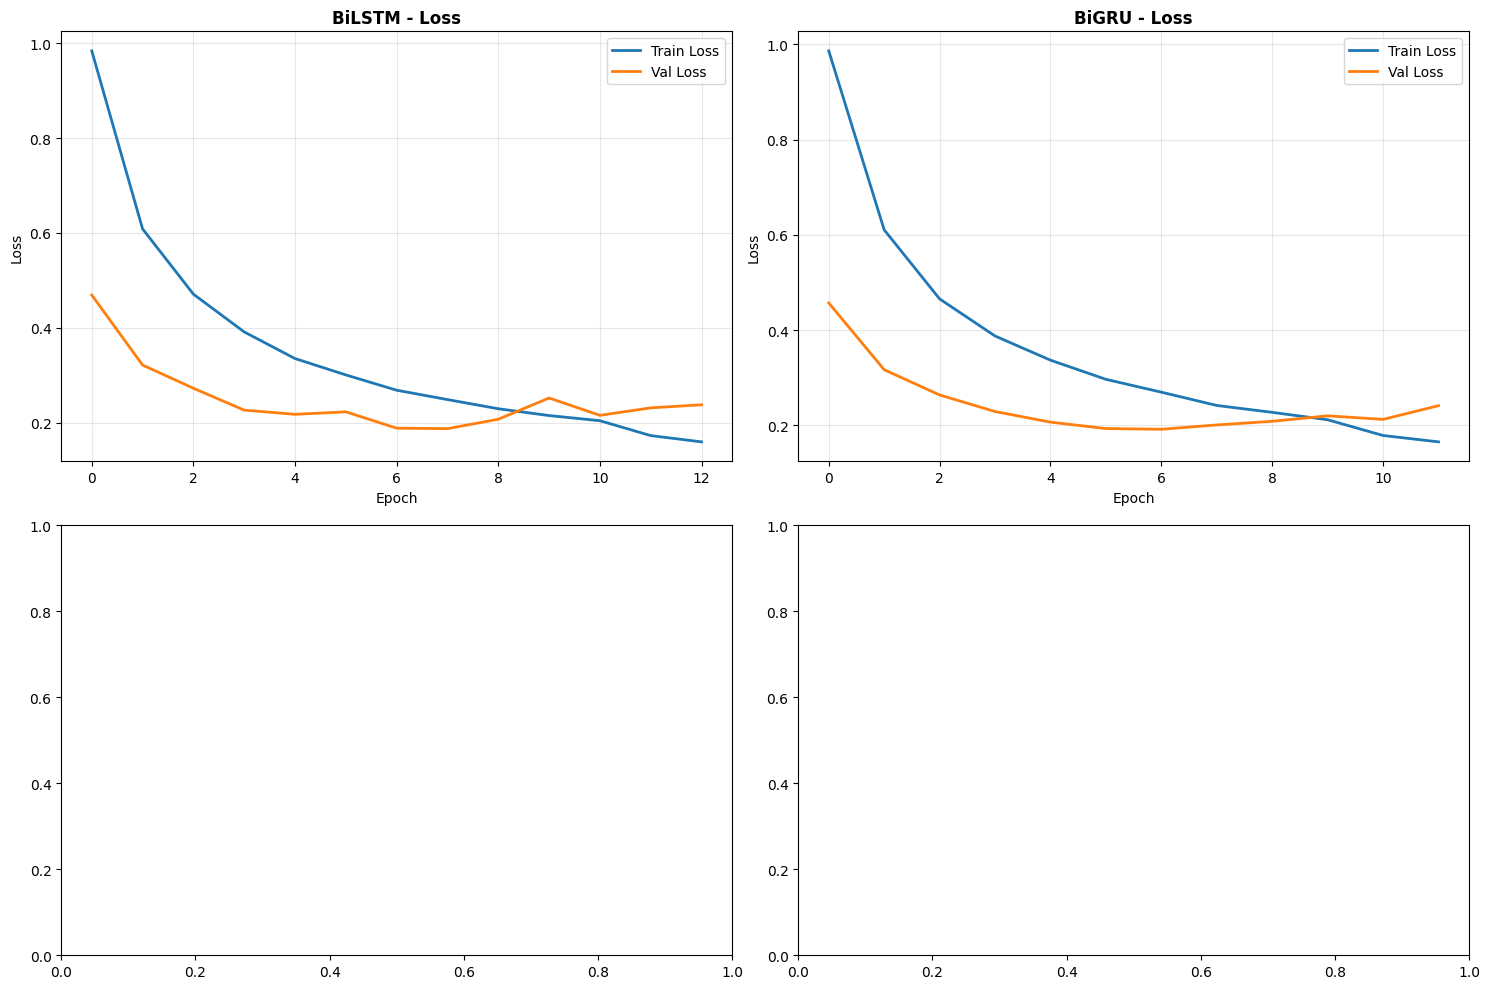

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (model_name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
        
    history = result['history']
    
    axes[row, col].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[row, col].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[row, col].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [29]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("\n Tokenizer saved as 'tokenizer.pkl'")

print("\n" + "="*50)
print(" TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print("\n Files created:")
print("1. best_sentiment_model.h5 - Best trained model")
print("2. tokenizer.pkl - Tokenizer for text preprocessing")
print("3. eda_visualization.png - EDA plots")
print("4. confusion_matrix.png - Confusion matrix")
print("5. training_history.png - Training history")
print("\n Ready for Gradio deployment!")


 Tokenizer saved as 'tokenizer.pkl'

 TRAINING COMPLETED SUCCESSFULLY!

 Files created:
1. best_sentiment_model.h5 - Best trained model
2. tokenizer.pkl - Tokenizer for text preprocessing
3. eda_visualization.png - EDA plots
4. confusion_matrix.png - Confusion matrix
5. training_history.png - Training history

 Ready for Gradio deployment!


In [ ]:
# ============================================
# GRADIO DEPLOYMENT - TWITTER SENTIMENT ANALYSIS (BiLSTM)
# ============================================

import gradio as gr
import numpy as np
import pickle
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ============================================
# DOWNLOAD NLTK DATA
# ============================================
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ============================================
# LOAD MODEL AND TOKENIZER
# ============================================
print("Loading model and tokenizer...")
model = keras.models.load_model('best_sentiment_model_BiLSTM.h5')  # ✅ اسم الموديل الصحيح
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("✅ Model and tokenizer loaded successfully!")

# ============================================
# PREPROCESSING FUNCTIONS
# ============================================
MAX_LEN = 100

def clean_text(text):
    """Clean and preprocess text"""
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    """Full preprocessing pipeline"""
    text = clean_text(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# ============================================
# PREDICTION FUNCTION
# ============================================
def predict_sentiment(text):
    """Predict sentiment of input text"""
    if not text or text.strip() == "":
        return "⚠️ Please enter some text!", None
    
    # Preprocess
    cleaned = preprocess_text(text)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(padded, verbose=0)[0]
    
    # 4 Sentiment classes
    sentiments = ['😠 Negative', '😐 Neutral', '😊 Positive', '🗑️ Irrelevant']
    predicted_class = np.argmax(prediction)
    predicted_sentiment = sentiments[predicted_class]
    confidence = prediction[predicted_class] * 100
    
    # Create result text
    result = f"""
## 🎯 Prediction Result

**Sentiment:** {predicted_sentiment}  
**Confidence:** {confidence:.2f}%

---

### 📊 All Class Probabilities:
- 😠 **Negative:** {prediction[0]*100:.2f}%
- 😐 **Neutral:** {prediction[1]*100:.2f}%
- 😊 **Positive:** {prediction[2]*100:.2f}%
- 🗑️ **Irrelevant:** {prediction[3]*100:.2f}%

---

### 📝 Processed Text:
"""
    
    # Confidence dict for output visualization
    confidence_dict = {
        "😠 Negative": float(prediction[0]),
        "😐 Neutral": float(prediction[1]),
        "😊 Positive": float(prediction[2]),
        "🗑️ Irrelevant": float(prediction[3])
    }
    
    return result, confidence_dict

# ============================================
# EXAMPLES
# ============================================
examples = [
    ["I love how smooth this update is! Everything runs perfectly!"],
    ["This is the worst experience ever, so many bugs and crashes."],
    
    ["Totally irrelevant comment, doesn't relate to the topic at all."],
    ["Feeling super happy today!"],
    ["This tweet makes no sense at all."]
]

# ============================================
# CREATE GRADIO INTERFACE
# ============================================
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    
    # Header
    gr.Markdown("""
    # 🐦 Twitter Sentiment Analysis (BiLSTM)
    
    Analyze the **sentiment** of any tweet or short text using a BiLSTM deep learning model.  
    It classifies text into 4 categories:
    - 😠 Negative  
    - 😐 Neutral  
    - 😊 Positive  
    - 🗑️ Irrelevant
    
    ---
    """)
    
    with gr.Row():
        with gr.Column(scale=2):
            text_input = gr.Textbox(
                label="📝 Enter your tweet or text:",
                placeholder="Type or paste a tweet here...",
                lines=4
            )
            
            with gr.Row():
                submit_btn = gr.Button("🚀 Analyze Sentiment", variant="primary", size="lg")
                clear_btn = gr.Button("🔄 Clear", variant="secondary")
            
            gr.Examples(
                examples=examples,
                inputs=text_input,
                label="💡 Try these examples:"
            )
        
        with gr.Column(scale=2):
            output_text = gr.Markdown(label="Results")
            output_plot = gr.Label(label="📊 Confidence Scores", num_top_classes=4)
    
    gr.Markdown("""
    ---
    **Model Info:**  
    - Architecture: BiLSTM  
    - Classes: 4 (Negative, Neutral, Positive, Irrelevant)  
    - Preprocessing: tokenization, stopword removal, lemmatization  
    
    **Usage Tip:**  
    Works best with short, natural sentences (tweets, comments, reviews, etc.)
    """)
    
    # Button actions
    submit_btn.click(
        fn=predict_sentiment,
        inputs=text_input,
        outputs=[output_text, output_plot]
    )
    
    clear_btn.click(
        lambda: ("", None),
        outputs=[text_input, output_text]
    )

# ============================================
# LAUNCH
# ============================================
if __name__ == "__main__":
    demo.launch(share=True, debug=True)
    print("\n🎉 Gradio interface is running!")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading model and tokenizer...
✅ Model and tokenizer loaded successfully!
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://fdfce4fc2f7ee88e22.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install langdetect deep-translator


In [33]:
!pip freeze >requirments.txt

In [ ]:
print ('hello amola')